In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 2.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633963 sha256=64011d7c4d70c46f01a9ed48b08aa30ba22aac76a73be1244574984971ae97ea
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np 
# from sklearn.metrics.pairwise import cosine_similarity 
# from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
from surprise import Reader, Dataset, KNNBasic 
from surprise.model_selection import cross_validate 
from surprise import SVD

import tweepy
import re

import nltk  
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np                                                               
import matplotlib.pyplot as plt
from collections import Counter


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Datasets

In [ ]:
user_df = pd.read_csv('/content/drive/MyDrive/My data files/sma_final/u.data', header = None, sep = '\t')

genre_df = pd.read_csv('/content/drive/MyDrive/My data files/sma_final/u.genre', header = None, sep = '|')

movie_df = pd.read_csv('/content/drive/MyDrive/My data files/sma_final/u.item', sep='|', header = None , encoding='latin-1')

In [ ]:
user_df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
user_df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
genre_df

,0,1
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


In [ ]:
movie_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Setting the column names for movie_df
mov_df_col_names = ['movie id', 'title', 'release date', 'video release date', 'IMDb URL']+genre_df[0].tolist()
movie_df.columns = mov_df_col_names
movie_df

,movie id,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


([<matplotlib.axis.YTick at 0x7fab33481b10>,
 <a list of 5 Text major ticklabel objects>)

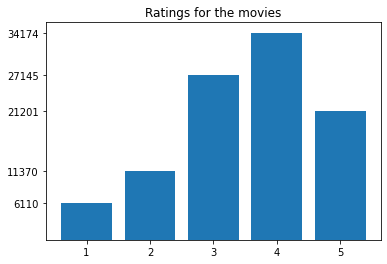

In [ ]:
# Rating Analysis.
ratings = user_df['rating'].tolist()
counts = [ratings.count(1),ratings.count(2),ratings.count(3),ratings.count(4),ratings.count(5)]

top=[('1',ratings.count(1)),('2',ratings.count(2)),('3',ratings.count(3)),('4',ratings.count(4)),('5',ratings.count(5))]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.8

plt.bar(xs, ys, width, align='center')
plt.title('Ratings for the movies')
plt.xticks(xs, labels) 
plt.yticks(ys)

# Twitter Analysis of the movies

In [ ]:
CONSUMER_TOKEN = "ADD YOURS"
CONSUMER_SECRET = "ADD YOURS"

auth = tweepy.OAuthHandler(CONSUMER_TOKEN, CONSUMER_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# Preparing a new dataframe for storing the sentiment scores of the movies (positive, negative, and neutral).
movie_names = movie_df['title'].tolist()
sentiments_df = pd.DataFrame(movie_names)
sentiments_df["positive"] = np.nan
sentiments_df["negative"] = np.nan
sentiments_df["neutral"] = np.nan

In [ ]:
sentiments_df

,0,positive,negative,neutral
0,Toy Story (1995),NaN,NaN,NaN
1,GoldenEye (1995),NaN,NaN,NaN
2,Four Rooms (1995),NaN,NaN,NaN
3,Get Shorty (1995),NaN,NaN,NaN
4,Copycat (1995),NaN,NaN,NaN
...,...,...,...,...
1677,Mat' i syn (1997),NaN,NaN,NaN
1678,B. Monkey (1998),NaN,NaN,NaN
1679,Sliding Doors (1998),NaN,NaN,NaN
1680,You So Crazy (1994),NaN,NaN,NaN


In [ ]:
# Function for pre processing movie names before searching on twitter.
def text_process(org_string):
  mod_string = re.sub(r'\([^)]*\)', '', org_string)
  mod_string = mod_string.replace(" ", "")
  return mod_string

In [ ]:
sid = SentimentIntensityAnalyzer() # VADER for sentiment analysis

# Function for getting sentiment scores of the comments (positive, negative, neutral)
def get_scores (tweet_list):
  scores = []
  neg_sum, pos_sum, neu_sum = 0, 0, 0
  n_counter, p_counter, neu_counter = 0, 0, 0

  for item in tweet_list:
    scores.append(sid.polarity_scores(item))

  for i in range (0, len(scores)):
    neg_sum += scores[i]['neg']
    n_counter += 1

    pos_sum += scores[i]['pos']
    p_counter += 1

    neu_sum += scores[i]['neu']
    neu_counter += 1

  pos_neg_neu = [(round((pos_sum/n_counter)*100)), (round((neg_sum/n_counter)*100)), (round((neu_sum/n_counter)*100))]
  return pos_neg_neu

In [ ]:
# Getting sentiment scores for all the movies.
pnn = []
for index, row in sentiments_df.iterrows():
  moviename = sentiments_df[0][index]
  moviename = text_process(moviename)
  tweets = []
  for tweet in tweepy.Cursor(api.search, q=moviename, count=10, lang='en').items(10):
    tweets.append(tweet.text)
  if not tweets:
    pass
  else:
    pnn = get_scores(tweets)
    print(index, pnn)
    sentiments_df['positive'][index] = pnn[0]
    sentiments_df['negative'][index] = pnn[1]
    sentiments_df['neutral'][index] = pnn[2]

0 [9, 0, 91]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


1 [7, 7, 86]
2 [17, 0, 83]
3 [10, 5, 85]
4 [6, 8, 86]
6 [12, 6, 82]
7 [13, 7, 80]
8 [4, 14, 81]
9 [7, 2, 91]
10 [5, 8, 87]
11 [11, 2, 87]
13 [16, 5, 79]
15 [0, 9, 91]
16 [10, 0, 90]
20 [10, 11, 79]
21 [9, 1, 90]
22 [9, 8, 83]
23 [10, 3, 87]
24 [11, 2, 87]
25 [30, 0, 70]
26 [8, 2, 90]
27 [2, 1, 97]
28 [21, 7, 73]
29 [8, 0, 92]
30 [17, 4, 79]
31 [11, 7, 82]
32 [8, 10, 82]
33 [0, 3, 97]
35 [11, 8, 81]
36 [10, 1, 89]
37 [10, 6, 84]
38 [7, 5, 88]
40 [20, 6, 74]
41 [8, 5, 87]
42 [4, 8, 87]
44 [1, 0, 99]
45 [5, 8, 87]
46 [5, 7, 88]
47 [4, 1, 95]
48 [10, 8, 82]
49 [19, 13, 68]
50 [26, 5, 70]
52 [7, 9, 84]
53 [2, 12, 86]
54 [9, 2, 89]
55 [24, 0, 76]
56 [7, 10, 83]
57 [11, 0, 89]
59 [0, 0, 100]
61 [6, 3, 90]
62 [10, 5, 86]
63 [11, 10, 78]
65 [12, 4, 84]
67 [2, 5, 93]
68 [10, 2, 88]
69 [21, 7, 72]
70 [21, 3, 76]
71 [9, 4, 87]
72 [11, 2, 87]
75 [0, 0, 100]
76 [9, 11, 80]
77 [14, 9, 77]
78 [8, 3, 89]
81 [10, 2, 88]
82 [3, 2, 95]
84 [11, 3, 86]
85 [15, 0, 85]
86 [59, 0, 41]
87 [19, 3, 78]
88 [13, 0,

In [ ]:
# sentiments_df.to_csv('/content/drive/MyDrive/My data files/sentiments.csv')

In [ ]:
# Loading the sentiment scores from checkpoint.
sentiments_df = pd.read_csv('/content/drive/MyDrive/My data files/sentiments.csv')

# Collaborative Filtering (Matrix Factorisation)

In [ ]:
X = user_df
y = user_df['user_id']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y)

In [ ]:
user_df = user_df.drop(columns = 'timestamp')
reader = Reader()

data = Dataset.load_from_df(user_df, reader)

SVD 


In [ ]:
svd = SVD()

In [ ]:
cross_validate(svd, data, measures=['RMSE'], cv = 3)

{'fit_time': (4.601743459701538, 5.122843265533447, 4.751399993896484),
 'test_rmse': array([0.95397746, 0.93955757, 0.94077522]),
 'test_time': (0.2893235683441162, 0.34169507026672363, 0.27794623374938965)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
svd.predict(1, 61) # Testing movie id 61, and user 1.

Prediction(uid=1, iid=61, r_ui=None, est=3.907101503946332, details={'was_impossible': False})

In [ ]:
user_df[user_df['user_id'] == 1] 

,user_id,item_id,rating
202,1,61,4
305,1,189,3
333,1,33,4
334,1,160,4
478,1,20,4
...,...,...,...
92049,1,28,4
92487,1,172,5
94019,1,122,3
96699,1,152,5


In [ ]:
X_test[X_test['user_id'] == 1] 

,user_id,item_id,rating,timestamp
78817,1,216,5,876892701
12948,1,250,4,874965706
6965,1,212,4,875072895
11663,1,264,2,875071713
31742,1,205,3,878542909
67098,1,139,3,878543216
14025,1,241,4,878543133
83307,1,3,4,878542960
3909,1,177,5,876892701
7993,1,107,4,875241619


In [ ]:
svd.predict(1, 56) # Testing from test sample.

Prediction(uid=1, iid=56, r_ui=None, est=4.164009055010925, details={'was_impossible': False})

# Neural Collaborative Filtering

In [ ]:
user_ids = user_df['user_id'].tolist() 

In [ ]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [ ]:
movie_ids = user_df["item_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [ ]:
user_df["user"] = user_df["user_id"].map(user2user_encoded)
user_df["movie"] = user_df["item_id"].map(movie2movie_encoded)

In [ ]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

In [ ]:
user_df["rating"] = user_df["rating"].values.astype(np.float32)

In [ ]:
min_rating = min(user_df["rating"])
max_rating = max(user_df["rating"])

In [ ]:
df = user_df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
# function for reverse one-hot to get genres column
def reverse_onehot(row):
  for c in genres.columns:
    if row[c]==1:
      return c

In [ ]:
genres = pd.DataFrame(movie_df, columns=[
       'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'])

genres = genres.apply(reverse_onehot, axis=1)
movie_df['genres'] = genres.tolist()

In [ ]:
movie_df['genres']

0       Animation
1          Action
2        Thriller
3          Action
4           Crime
          ...    
1677        Drama
1678      Romance
1679        Drama
1680       Comedy
1681        Drama
Name: genres, Length: 1682, dtype: object

In [ ]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6751 - val_loss: 0.6610
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6501 - val_loss: 0.6446
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6373 - val_loss: 0.6364
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.6307 - val_loss: 0.6323
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6272 - val_loss: 0.6303
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6254 - val_loss: 0.6292
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6243 - val_loss: 0.6287
Epoch 8/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6236 - val_loss: 0.6284
Epoch 9/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6232 - val_loss: 0.6282
Epoch 10/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.622

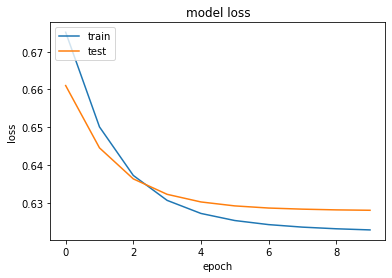

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:

# top recommendations for a user.
# user_id = user_df.user_id.sample(1).iloc[0] # Random User
user_id = 9
movies_watched_by_user = user_df[user_df.user_id == user_id]

movies_not_watched = movie_df[
    ~movie_df["movie id"].isin(movies_watched_by_user.item_id.values)
]["movie id"]

movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)


movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)


ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [ ]:
print("\nMovies with high ratings from user #{}:".format(user_id))
print("\n")
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .item_id.values
)
movie_df_rows = movie_df[movie_df["movie id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres) 

print("\n\n")
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movie id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres) 


Movies with high ratings from user #9:


Star Wars (1977) : Action
Evil Dead II (1987) : Action
Face/Off (1997) : Action
Bridges of Madison County, The (1995) : Drama
Dark City (1998) : Film-Noir



Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime
Shawshank Redemption, The (1994) : Drama
Silence of the Lambs, The (1991) : Drama
Wallace & Gromit: The Best of Aardman Animation (1996) : Animation
Wrong Trousers, The (1993) : Animation
12 Angry Men (1957) : Drama
Schindler's List (1993) : Drama
Close Shave, A (1995) : Animation
To Kill a Mockingbird (1962) : Drama
Rear Window (1954) : Mystery


# Hybrid Approach

In [ ]:
recommendations = movie_df[movie_df["movie id"].isin([recommended_movie_ids[0], recommended_movie_ids[1], recommended_movie_ids[2], recommended_movie_ids[3], recommended_movie_ids[4],
                                  recommended_movie_ids[5], recommended_movie_ids[6], recommended_movie_ids[7], recommended_movie_ids[8], recommended_movie_ids[9]])]

recommendations['postive'] = sentiments_df['positive']
recommendations['negative'] = sentiments_df['negative']
recommendations['neutral'] = sentiments_df['neutral']                       

recommendations.drop(['release date', 'video release date', 'IMDb URL',
       'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'genres'], axis=1, inplace=True)

In [ ]:
recommendations.columns

Index(['movie id', 'title', 'postive', 'negative', 'neutral'], dtype='object')

In [ ]:
recommendations

,movie id,title,postive,negative,neutral
11,12,"Usual Suspects, The (1995)",11.0,2.0,87.0
63,64,"Shawshank Redemption, The (1994)",11.0,10.0,78.0
97,98,"Silence of the Lambs, The (1991)",9.0,3.0,88.0
126,127,"Godfather, The (1972)",4.0,0.0,96.0
173,174,Raiders of the Lost Ark (1981),5.0,1.0,94.0
312,313,Titanic (1997),2.0,3.0,95.0
317,318,Schindler's List (1993),0.0,0.0,100.0
356,357,One Flew Over the Cuckoo's Nest (1975),0.0,0.0,100.0
426,427,To Kill a Mockingbird (1962),13.0,10.0,77.0
602,603,Rear Window (1954),22.0,11.0,68.0


In [ ]:
recommendations_dict = {}
for index, row in recommendations.iterrows():
  # print(recommendations['postive'][index]/recommendations['negative'][index], recommendations['title'][index])
  recommendations_dict[recommendations['title'][index]] = recommendations['postive'][index]/recommendations['negative'][index]
  # -recommendations['negative'][index]+recommendations['neutral'][index]

In [ ]:
recommendations_dict

{'Godfather, The (1972)': inf,
 "One Flew Over the Cuckoo's Nest (1975)": nan,
 'Raiders of the Lost Ark (1981)': 5.0,
 'Rear Window (1954)': 2.0,
 "Schindler's List (1993)": nan,
 'Shawshank Redemption, The (1994)': 1.1,
 'Silence of the Lambs, The (1991)': 3.0,
 'Titanic (1997)': 0.6666666666666666,
 'To Kill a Mockingbird (1962)': 1.3,
 'Usual Suspects, The (1995)': 5.5}

In [ ]:
top5 = sorted(recommendations_dict, key=recommendations_dict.get, reverse=True)[:5]

In [ ]:
top5

['Godfather, The (1972)',
 'Usual Suspects, The (1995)',
 'Raiders of the Lost Ark (1981)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)']